## Final Project.ipynb



### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.
- As always, the data can be found in the dropbox folder: https://www.dropbox.com/scl/fo/hrjspow2cpstfnoeqb23v/h?rlkey=j4fohf1s4e6fdy49p7bs71b7l&dl=0.
- Please download the file `MasterData_small.parquet`. 

In [195]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We now choose whether to import data directly from WRDS (`import_data` = True) or to load data from dropbox (`import_data` = False). If you choose to load data from dropbox, make sure to define the data directoy (`_DATA_DIR`). Also, define a directory where you'd like to store the strategy returns (`_STRATEGY_DIR`). In future versions, we'll use a much larger data set, named `MasterData.parquet` (it is already in dropbox), but the core strategies will be constructed using `MasterData_small.parquet`. 

In [196]:
import_data = False             # <-- Edit this line
_DATA_DIR = 'C:/Users/Zixian Li/Documents/Booth/Academic/Fall 2023/Quant PM/Week Three/Data'           # <-- Edit this line
_STRATEGY_DIR = 'C:/Users/Zixian Li/Documents/Booth/Academic/Fall 2023/Quant PM/Week Three/Strategy'   # <-- Edit this line

In [197]:
   _SORT_FREQUENCY = 'June'        # Either "Monthly" or "June"
_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2010-01-01'
_SAMPLE_END = '2023-07-31'
_NUM_PORT = 5

## Only using Intangible Asset as a signal

In [198]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')


> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


In [199]:
#Build the signal

df_full['signal'] = df_full['intan'] / df_full['at']

In [200]:
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)

> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...


> Merging strategy returns with Fama and French factor returns...


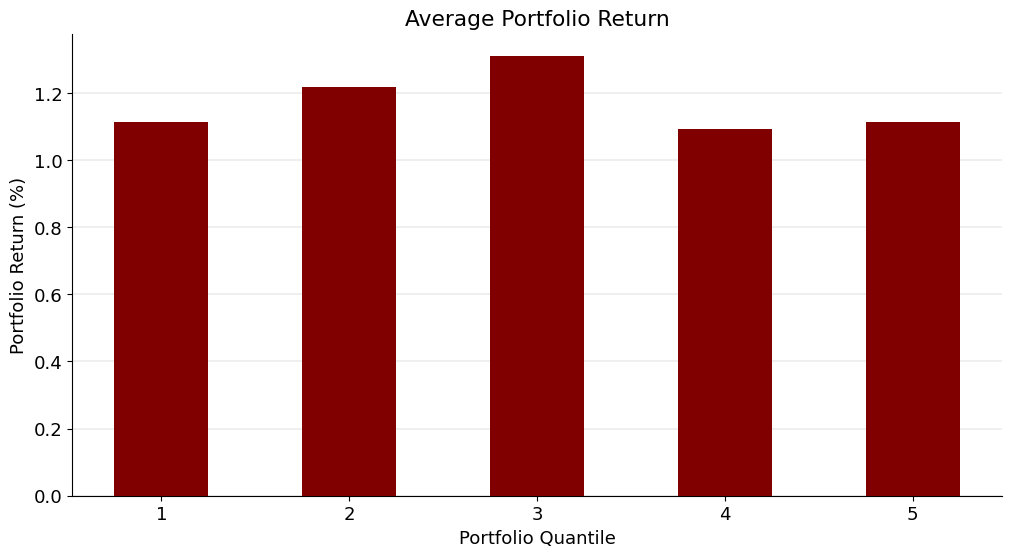

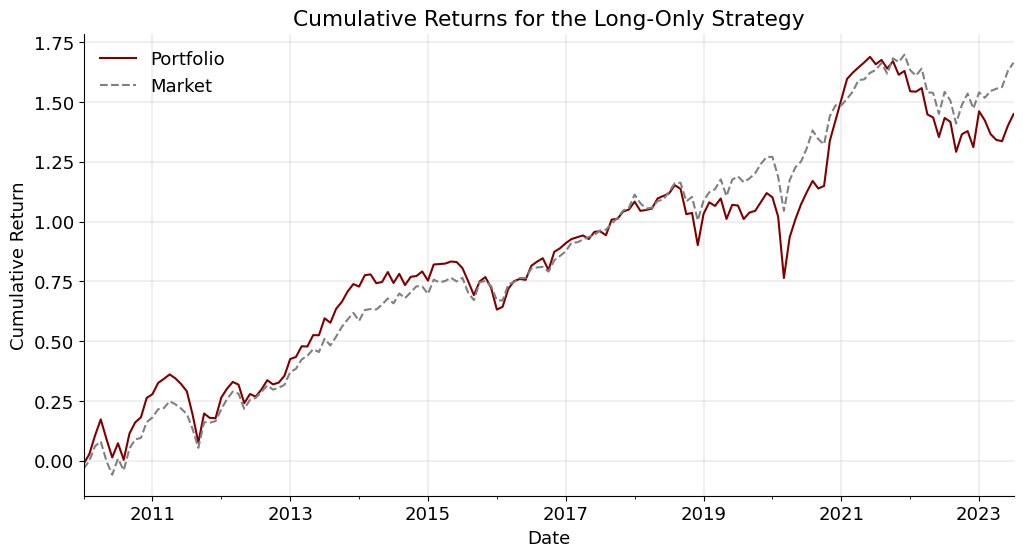

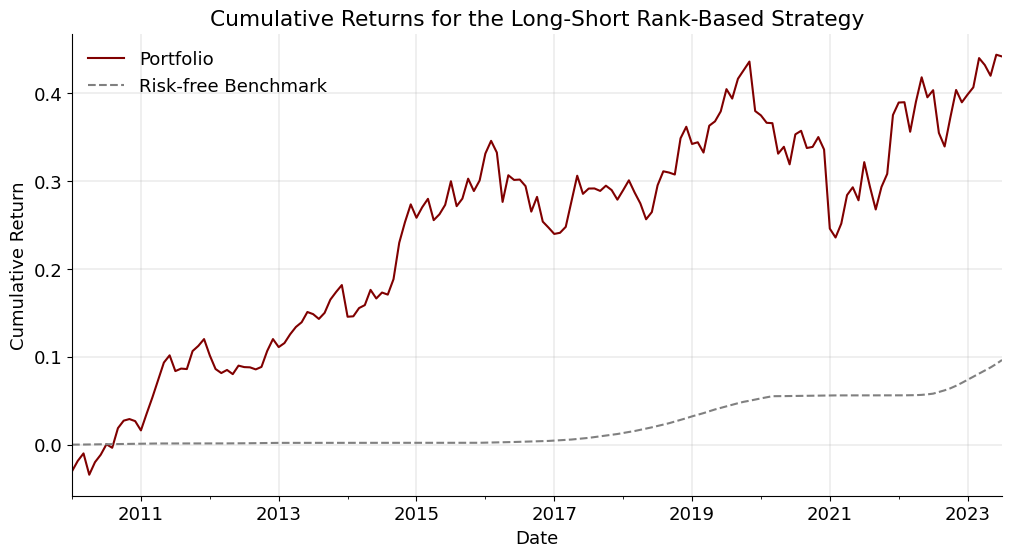

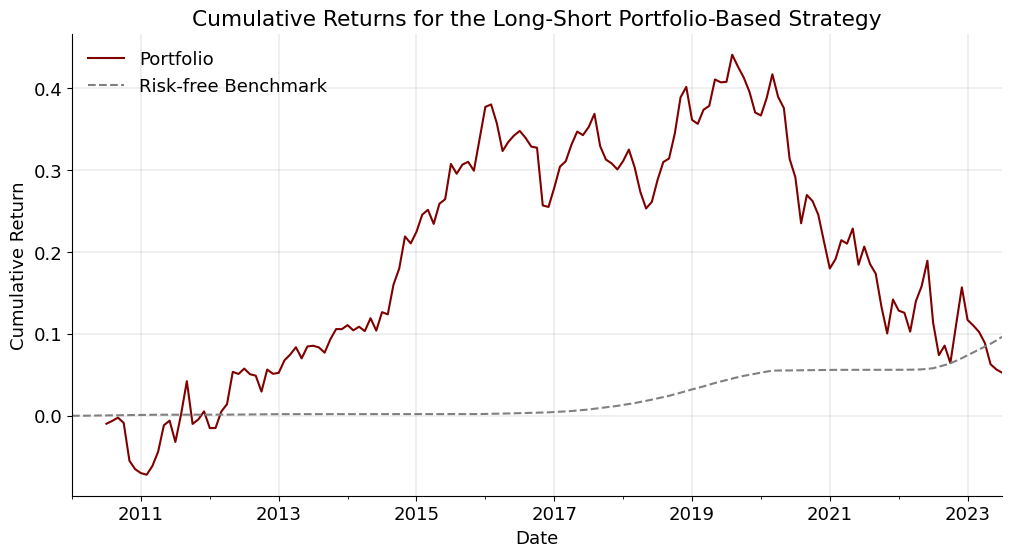

In [201]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [202]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)        (2)      (3)       (4)        (5)       (6)    
----------------------------------------------------------------------------
const          0.0027     -0.0035*  0.0017   0.0019     -0.0011   0.0010    
               (0.0018)   (0.0020)  (0.0017) (0.0017)   (0.0010)  (0.0016)  
mktrf          -0.2381*** 1.2052*** 0.0658*  -0.1738*** 1.0295*** 0.1322*** 
               (0.0395)   (0.0436)  (0.0372) (0.0400)   (0.0232)  (0.0371)  
hml                                          0.0108     0.0532*   0.0742    
                                             (0.0508)   (0.0295)  (0.0471)  
smb                                          -0.3075*** 0.8259*** -0.3287***
                                             (0.

## Using Intangible Asset and Value as the signal

In [203]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


In [204]:
df_full['intangible'] = df_full['intan'] / df_full['at']
yearly_stats = df_full.groupby('fyear')['intangible'].agg(['mean', 'std']).reset_index()

# Step 3: Merge these stats back into the original dataframe
df_full = df_full.merge(yearly_stats, on='fyear', suffixes=('', '_intan_yearly'))

# Step 4: Calculate the normalized profitability signal
df_full['intan_signal'] = (df_full['intangible'] - df_full['mean']) / df_full['std']

In [205]:
df_full['value'] = df_full['be'] / df_full['me']
yearly_stats = df_full.groupby('fyear')['value'].agg(['mean', 'std']).reset_index()

# Step 3: Merge these stats back into the original dataframe
df_full = df_full.merge(yearly_stats, on='fyear', suffixes=('', '_value_yearly'))

# Step 4: Calculate the normalized profitability signal
df_full['value_signal'] = (df_full['value'] - df_full['mean_value_yearly']) / df_full['std_value_yearly']

In [206]:
#Give 50% weight to each signal

df_full['signal'] = 0.5*df_full['intan_signal']+0.5*df_full['value_signal']

> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Merging strategy returns with Fama and French factor returns...


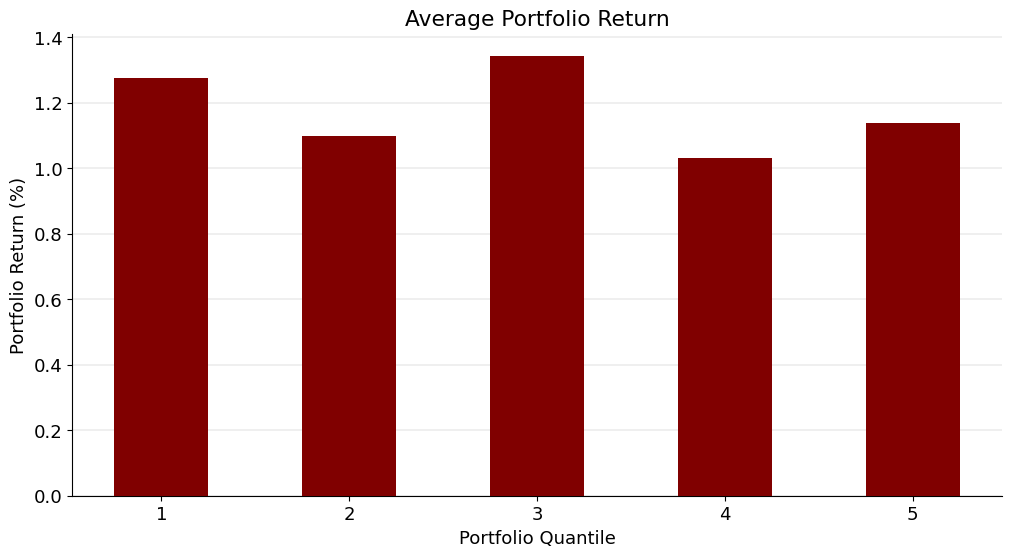

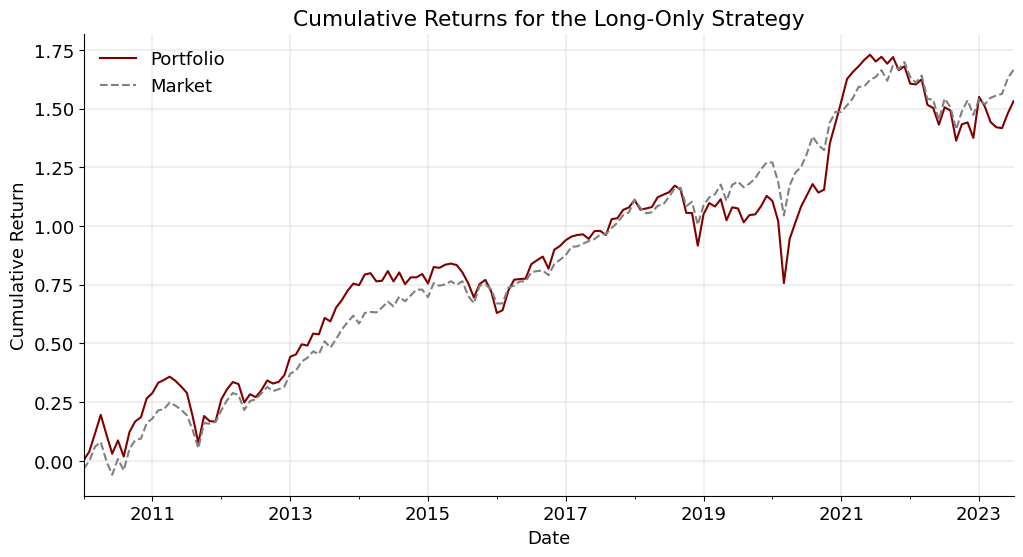

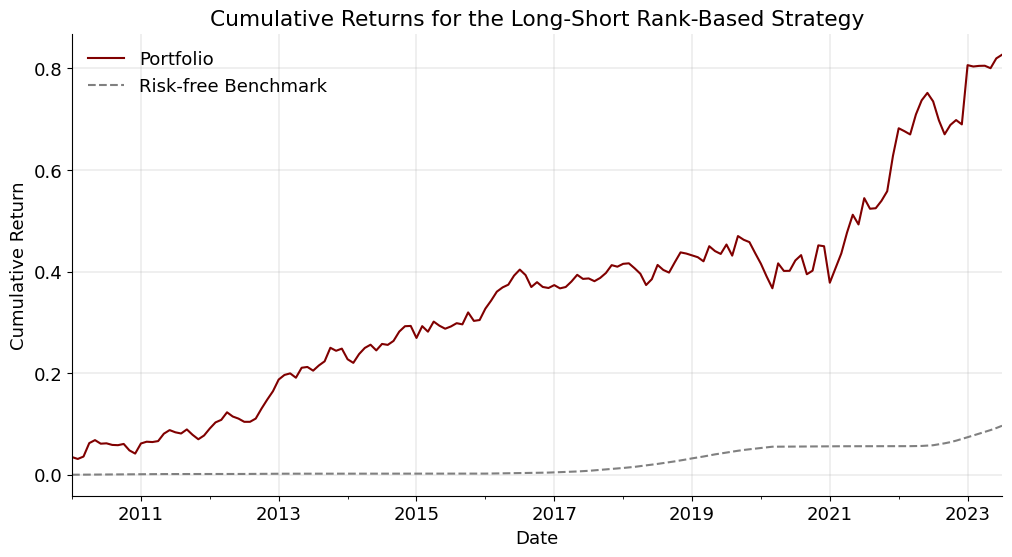

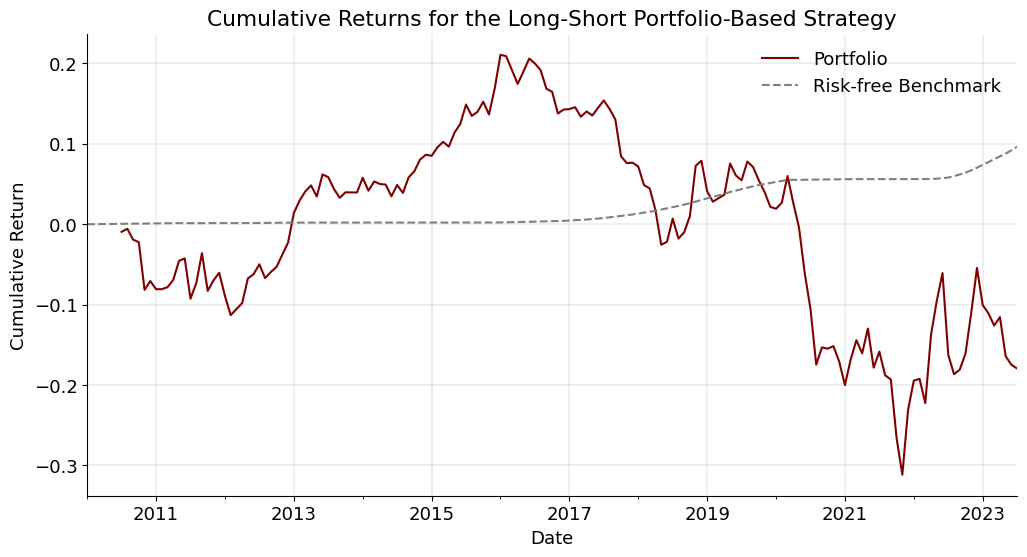

In [207]:
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [218]:
# qpm.analyze_strategy(df_rets, analysis_type = 'Summary')
# df_rets
df_rets['retP_rank_longonly'].mean()

0.01120282284396962

In [208]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)        (2)       (3)       (4)        (5)       (6)    
-----------------------------------------------------------------------------
const          0.0016     -0.0031   0.0032*   0.0015     -0.0006   0.0031**  
               (0.0020)   (0.0022)  (0.0017)  (0.0019)   (0.0013)  (0.0015)  
mktrf          -0.2643*** 1.2164*** 0.1102*** -0.2249*** 1.0343*** 0.1513*** 
               (0.0447)   (0.0487)  (0.0373)  (0.0445)   (0.0301)  (0.0365)  
hml                                           0.2711***  0.0935**  0.2365*** 
                                              (0.0565)   (0.0382)  (0.0464)  
smb                                           -0.2345*** 0.8494*** -0.2364***
                                       

### Using Intangible Asset, R&D expense and value as the signal

In [219]:
df_full['rnd']=df_full['xrd']/df_full['oancf']
early_stats = df_full.groupby('fyear')['rnd'].agg(['mean', 'std']).reset_index()

# Step 3: Merge these stats back into the original dataframe
df_full = df_full.merge(yearly_stats, on='fyear', suffixes=('', '_rnd_yearly'))

# Step 4: Calculate the normalized profitability signal
df_full['rnd_signal'] = (df_full['rnd'] - df_full['mean_rnd_yearly']) / df_full['std_rnd_yearly']

In [257]:
max_ret = 0.0  # Start with a very small number
best_x, best_y,best_z = 0, 0,0

for x in np.arange(0,1.1,0.1):
    for y in np.arange(0, 1.1 - x, 0.1): 
        z = 1-x-y
        if 0<=z<=1:
            df_test=df_full
            df_test['signal'] = x*df_test['intan_signal']+y*df_test['value_signal']+z*df_test['rnd_signal']
            df_test['signal'] = qpm.create_lag(df_test, var_name = 'signal', lag = 1)
            df = qpm.select_sample(df_test, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)
            df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
            ret_maximize = (df_rets['retP_rank_longonly'].mean()-0.010645)/df_rets['retP_rank_longonly'].std()
            if ret_maximize > max_ret:
                max_ret = ret_maximize
                best_x, best_y,best_z = x, y, z
            

> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...

In [258]:
best_x, best_y, best_z


(0.0, 0.4, 0.6)

> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
> Merging strategy returns with Fama and French factor returns...


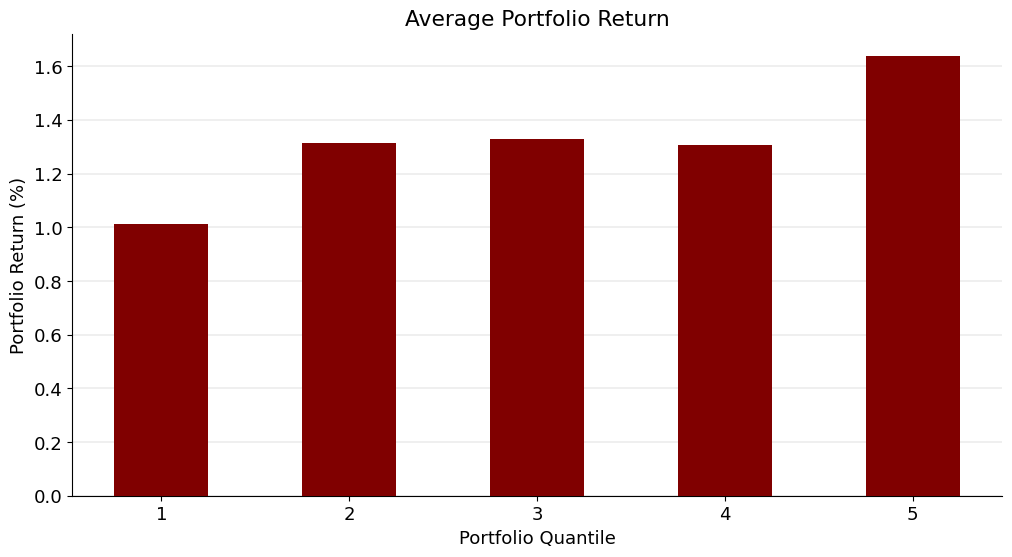

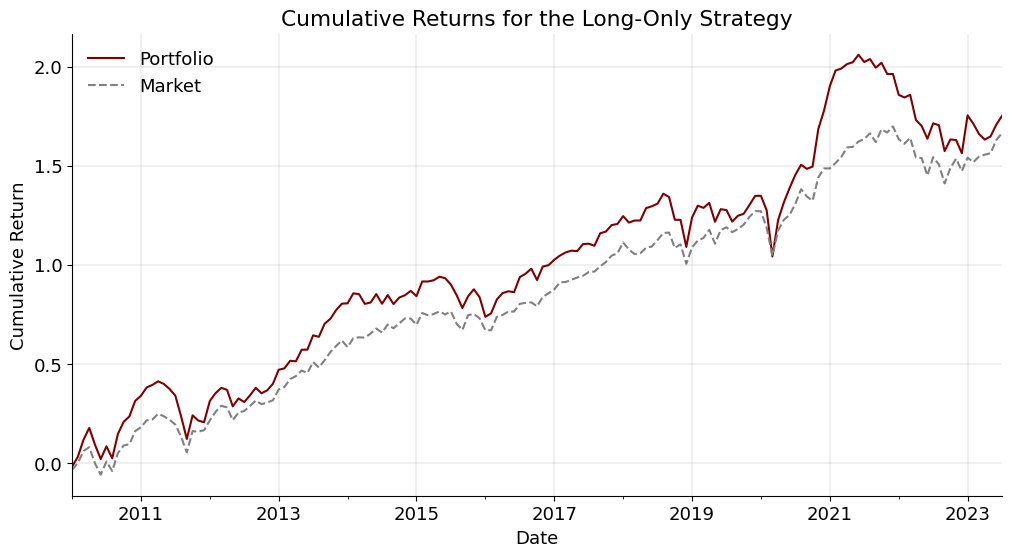

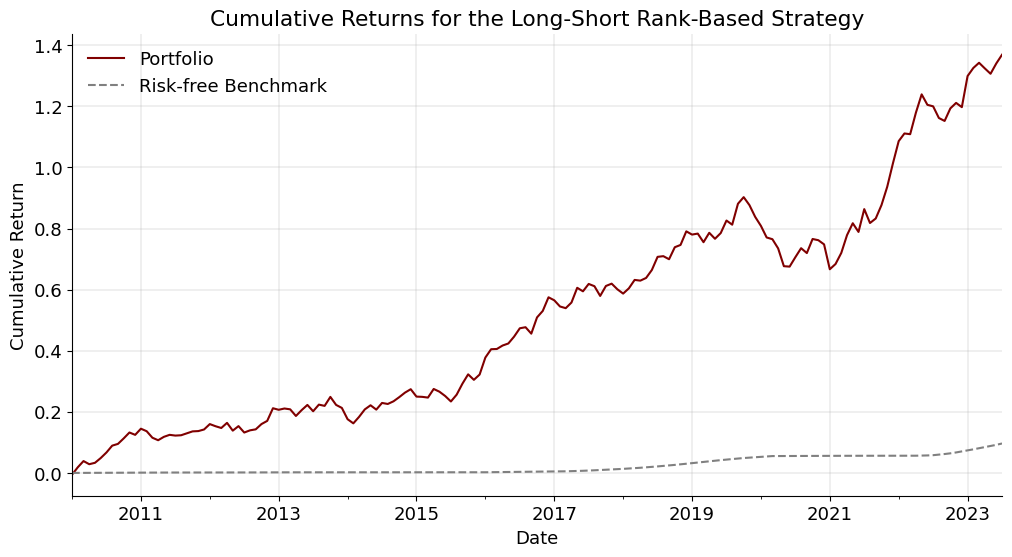

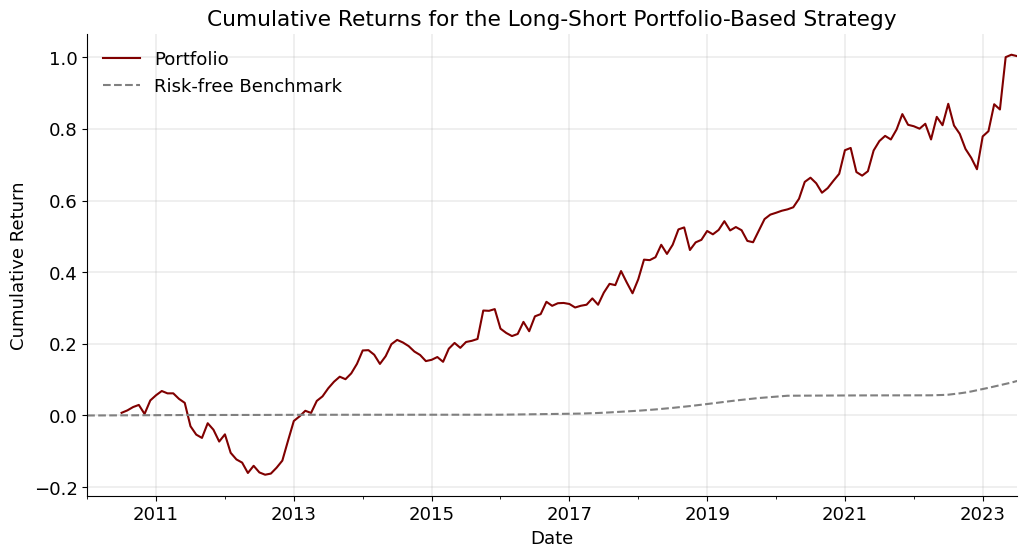

In [259]:
df_full['signal'] = best_x*df_test['intan_signal']+best_y*df_test['value_signal']+best_z*df_test['rnd_signal']
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)
df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [261]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   163.0  0.012660  0.061344 -0.207962 -0.018264  0.012867   
retP_rank_longshort  163.0  0.008229  0.028047 -0.078306 -0.010934  0.006597   
retF_vw              157.0  0.006256  0.030656 -0.065136 -0.011097  0.005148   
mktrf                163.0  0.010645  0.044144 -0.133900 -0.014000  0.013600   
smb                  163.0  0.000020  0.025947 -0.082800 -0.018000  0.001400   
hml                  163.0 -0.001521  0.033219 -0.138700 -0.018800 -0.004200   

                          75%       max  
retP_rank_longonly   0.045300  0.211104  
retP_rank_longshort  0.023603  0.103681  
retF_vw              0.020648  0.153647  
mktrf                0.034650  0.136500  
smb                  0.016100  0.071100  
hml                  0.013350  0.127500  


In [262]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)       (2)       (3)       (4)        (5)        (6)    
-----------------------------------------------------------------------------
const          0.0037    -0.0018   0.0084*** 0.0035     0.0006     0.0083*** 
               (0.0024)  (0.0024)  (0.0024)  (0.0023)   (0.0014)   (0.0021)  
mktrf          0.2255*** 1.2392*** -0.0171   0.2085***  1.0397***  0.0445    
               (0.0534)  (0.0524)  (0.0523)  (0.0550)   (0.0338)   (0.0491)  
hml                                          -0.2616*** -0.1407*** 0.4031*** 
                                             (0.0698)   (0.0429)   (0.0623)  
smb                                          0.1263     0.9726***  -0.3629***
                                       

In [ ]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))